In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

For our model, it's worth considering which countries in our dataset we consider as priveleged or unpriveleged. To this end, we will investigate which countries are overrepresented and underrepresented within our dataset.

In [2]:
user_df = pd.read_csv('../data/filtered_user_df.csv')
with open('../data/artist_location_codes.json', 'r') as file:
    # TODO: Why is Drake Polish?
    # Also, The Beatles are missing
    artist_locations = json.load(file)

In [3]:
play_count_df = user_df[['artist_name', 'play_count']]
play_count_df['country'] = play_count_df['artist_name'].map(artist_locations)

C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\2395307624.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_count_df['country'] = play_count_df['artist_name'].map(artist_locations)


In [4]:
country_play_counts = play_count_df.groupby('country').sum().sort_values(by='play_count')

C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\626412569.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_play_counts = play_count_df.groupby('country').sum().sort_values(by='play_count')


Plotting countries by total play count, we notice that our distribution is so skewed in favor of the top countries that the plot still appears exponential even when scaled logarithmically.

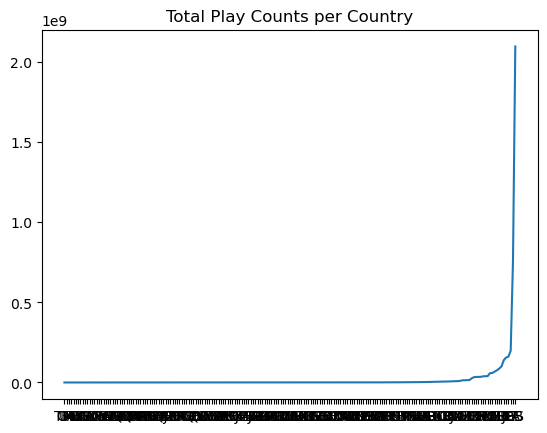

In [5]:
plt.title('Total Play Counts per Country')
plt.plot(country_play_counts['play_count'], scaley='log')

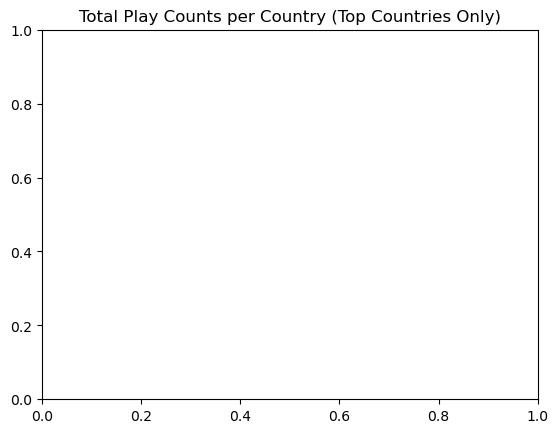

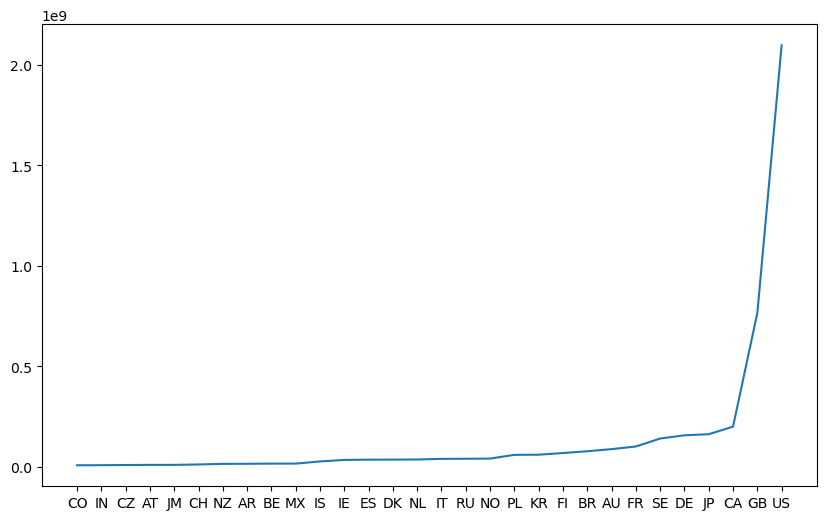

In [6]:
plt.title('Total Play Counts per Country (Top Countries Only)')
plt.figure(figsize=(10,6))
plt.plot(country_play_counts['play_count'].tail(30), scaley='log')

Something worth noting about our dataset is the high play counts of Scandinavian countries like Sweden, Norway, and Finland. These countries are primarily musically notable for their proliferation of metal bands. As metal is a relatively niche genre, the high placements for these countries could be caused by overrepresentations of metal listeners in our dataset. This may merit further investigation down the line. If metal bias is the cause, then it may be worth marking them as unpriveleged despite their high leads, as artists working in other genres besides metal in those countries could still be underrepresented in recommendations, and given the relative lack of popularity of metal, an overrepresentation of Scandinavian representation in specifically metal may not significantly affect the model's output.

In [7]:
country_counts = play_count_df.groupby('country').count().sort_values(by='play_count')

We notice a similar skew when plotting by the representation of artists per country in users' top 50 artists.

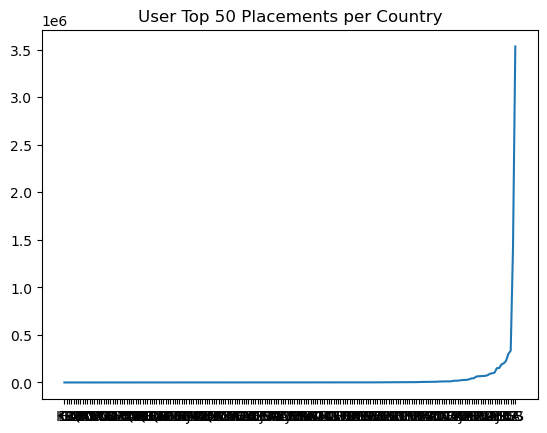

In [8]:
plt.title('User Top 50 Placements per Country')
plt.plot(country_counts['play_count'], scaley='log')

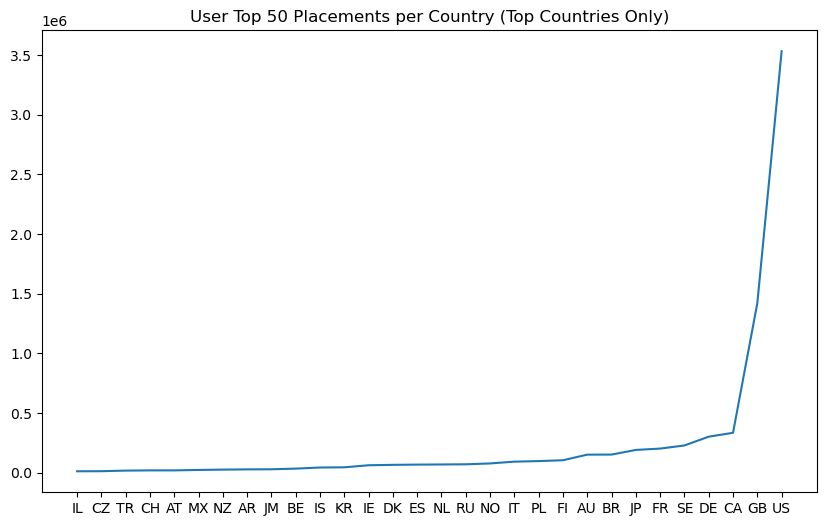

In [9]:
plt.figure(figsize=(10,6))
plt.title('User Top 50 Placements per Country (Top Countries Only)')
plt.plot(country_counts['play_count'].tail(30), scaley='log')

When plotting how many times more plays each country has than the previous highest, we notice that there are a few countries in the lead that have dramatically more plays than those behind them before the ratios begin to level out.

In [10]:
country_play_counts_offset = np.concatenate((np.array([1]), country_play_counts['play_count'][:-1].array))
prev_plays_ratios = country_play_counts['play_count'] / country_play_counts_offset

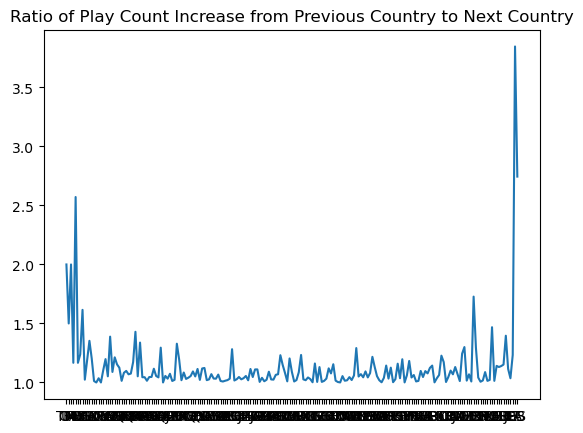

In [11]:
plt.title('Ratio of Play Count Increase from Previous Country to Next Country')
plt.plot(prev_plays_ratios)

To get a better understanding of where the ratios level out, we will plot just the top countries to find the cusp.

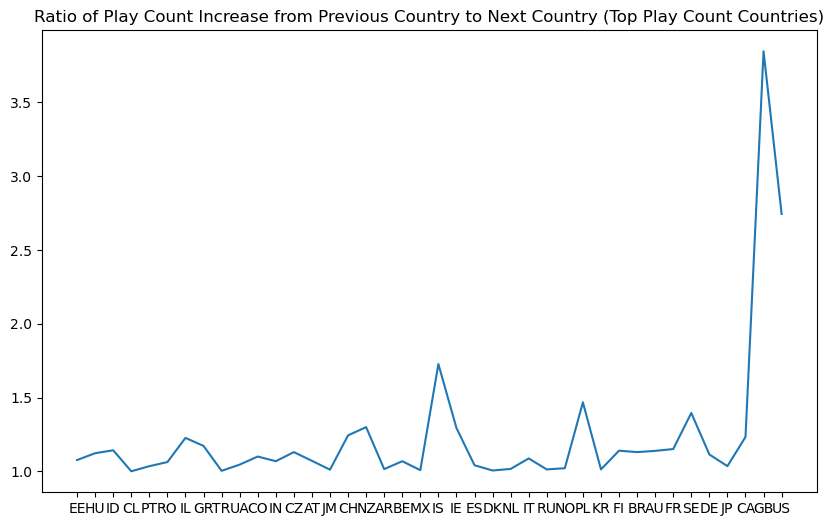

In [12]:
plt.figure(figsize=(10,6))
plt.title('Ratio of Play Count Increase from Previous Country to Next Country (Top Play Count Countries)')
plt.plot(prev_plays_ratios.tail(40))

It appears as if the last major spike in ratios is from Mexico to Iceland. As such, for this portion of our analysis, we will consider the subset of top countries from Iceland to the United States.

It is worth investigating whether the top countries are at the top because of general popularity or if a few extremely popular artists are skewing them high. To do so, we will plot the play counts of the top *k* artists of each country versus the average play counts of the countries.

In [13]:
top_plays_countries = prev_plays_ratios.tail(20).index

In [14]:
artist_summed_plays = play_count_df.groupby(['country', 'artist_name']).sum().reset_index()
country_mean_plays =  artist_summed_plays.groupby('country').mean()

C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\3287840095.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_mean_plays =  artist_summed_plays.groupby('country').mean()


In [15]:
country_mean_plays.loc[top_plays_countries]

,play_count
country,
IS,131420.556701
IE,61008.874307
ES,17175.894106
DK,37898.051479
NL,16521.045070
IT,12544.332896
RU,20055.135401
NO,32822.919702
PL,35390.975684


In [16]:
def plot_top_k_ratios(k, play_count_df, top_plays_countries):
    artist_summed_plays = play_count_df.groupby(['country', 'artist_name']).sum().reset_index()
    country_mean_plays =  artist_summed_plays.groupby('country').mean()
    country_counts_sorted = play_count_df.sort_values(by=['country', 'play_count'], ascending=[True, False])
    artist_plays_sorted = artist_summed_plays.sort_values(['country', 'play_count'], ascending=[True, False])
    top_k_per_country = artist_plays_sorted.groupby('country').head(k)
    mean_top_k_per_country = top_k_per_country.groupby('country').mean()
    top_to_avg_ratio = mean_top_k_per_country.loc[top_plays_countries].get('play_count') / country_mean_plays.loc[top_plays_countries].get('play_count')
    
    plt.title(f'Ratio of country\'s top {k} artists\' play counts to its average artist play counts')
    plt.plot(top_to_avg_ratio)

In the plots below, we can see that the U.S., France, and Japan demonstrate by far the most distance between play counts of top artists and average play counts.

C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\2573324048.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_mean_plays =  artist_summed_plays.groupby('country').mean()
C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\2573324048.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_top_k_per_country = top_k_per_country.groupby('country').mean()


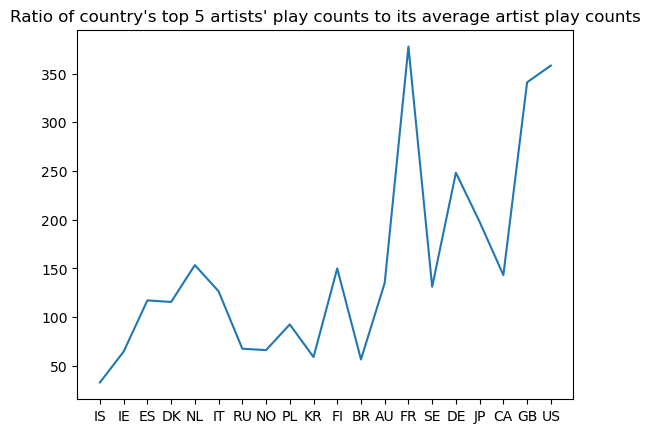

In [17]:
plot_top_k_ratios(5, play_count_df, top_plays_countries)

C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\2573324048.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_mean_plays =  artist_summed_plays.groupby('country').mean()
C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\2573324048.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_top_k_per_country = top_k_per_country.groupby('country').mean()


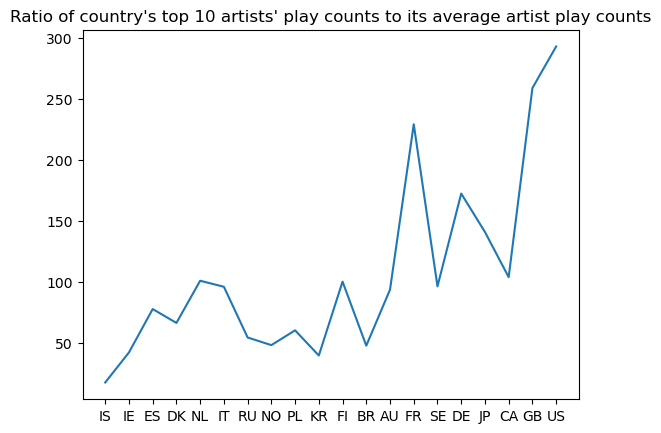

In [18]:
plot_top_k_ratios(10, play_count_df, top_plays_countries)

C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\2573324048.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_mean_plays =  artist_summed_plays.groupby('country').mean()
C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\2573324048.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_top_k_per_country = top_k_per_country.groupby('country').mean()


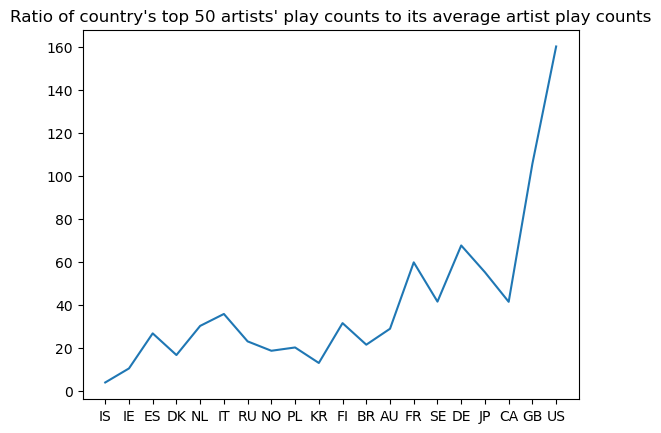

In [19]:
plot_top_k_ratios(50, play_count_df, top_plays_countries)

C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\2573324048.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_mean_plays =  artist_summed_plays.groupby('country').mean()
C:\Users\joshu\AppData\Local\Temp\ipykernel_2100\2573324048.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_top_k_per_country = top_k_per_country.groupby('country').mean()


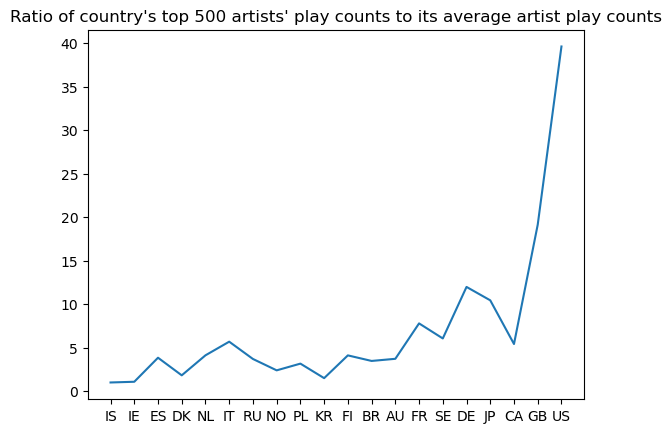

In [20]:
plot_top_k_ratios(500, play_count_df, top_plays_countries)

When interpreting these plots, it's important to consider the amount of artists in each country, as the US has more artists than, say, Iceland. As such, the top 500 artists in Iceland are going to be far more representative of the mean artists for that country than the top 500 in the US.